In [1]:
import numpy as np
import pandas as pd
import ecnconst
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from IPython.core.display import HTML

In [3]:
S = ecnconst.TCP_SYN
R = ecnconst.TCP_RST
SA = ecnconst.TCP_SYN | ecnconst.TCP_ACK
SEW = (ecnconst.TCP_SYN | ecnconst.TCP_ECE | ecnconst.TCP_CWR)
SAE = (ecnconst.TCP_SYN | ecnconst.TCP_ECE | ecnconst.TCP_ACK)
SAEW = (ecnconst.TCP_SYN | ecnconst.TCP_ECE | ecnconst.TCP_ACK | ecnconst.TCP_CWR)
QECT = (ecnconst.QOF_ECT0 | ecnconst.QOF_ECT1)
QECT0 = ecnconst.QOF_ECT0
QECT1 = ecnconst.QOF_ECT1
QCE = ecnconst.QOF_CE

In [4]:
RESULT_NOBODYHOME = 0
RESULT_OTHER = 1
RESULT_BROKEN = 2
RESULT_WORKS = 3

# Load data from csv

In [5]:
df = pd.read_csv('meas/m210415_02.csv')
df.shape
#                 names=['site','ip','port','rport','ecnstate','nodeid','connstate','fif','fsf','fuf','fir','fsr','fur','ttl'])

(99980, 14)

# Cleanup
Remove all flows without SYN

In [7]:
mask_initsyn = (df['fif'] & ecnconst.TCP_SYN) != 0
count_nosyn = df.shape[0] - sum(mask_initsyn)
print("Deleting flows without initial SYN: {} of {} ({:.1%}) were affected.".format(count_nosyn, df.shape[0], float(count_nosyn) / df.shape[0]))
df = df[df['fif'] & ecnconst.TCP_SYN != 0]

Deleting flows without initial SYN: 0 of 99980 (0.0%) were affected.


# ECN capability analysis

In [8]:
# ECN flags on TCP layer
df['ecnAttempted'] = np.bitwise_and(df['fsf'], SAEW) == SEW
df['ecnNegotiated'] = np.bitwise_and(df['fsr'], SAEW) == SAE

# ECN flags on IP layer
df["ecnCapable"] = np.bitwise_and(df["fur"], QECT0 << 8) > 0
df["ecnECT1"] = np.bitwise_and(df["fur"], QECT1 << 8) > 0
df["ecnCE"] = np.bitwise_and(df["fur"], QCE << 8) > 0

# check for SYN, SYN+ACK
df["didEstablish"] = ((np.bitwise_and(df["fsf"], S) == S) &
                      (np.bitwise_and(df["fsr"], SA) == SA))

In [9]:
print("Percentage of sucessfully ecn-enabled connections when asking for ecn: {:.2%}".format(
    (df['ecnNegotiated'] & df['connstate']).sum() / (df['ecnAttempted'] & df['connstate']).sum()
    ))

Percentage of sucessfully ecn-enabled connections when asking for ecn: 46.55%


In [10]:
conn_conflict = df[df['connstate'] != df['didEstablish']]
print("Number of connections reported differently by the OS and QoF: {} of {} ({:.2%})".format(conn_conflict.shape[0], df.shape[0], conn_conflict.shape[0] / df.shape[0]))

Number of connections reported differently by the OS and QoF: 1059 of 99980 (1.06%)


In [11]:
conn_conflict = df[(df['connstate'] == 1) & (df['connstate'] != df['didEstablish'])]
print("Number of connections reported as established by the OS but as failure by QoF: {} of {} ({:.2%})".format(conn_conflict.shape[0], df.shape[0], conn_conflict.shape[0] / df.shape[0]))

Number of connections reported as established by the OS but as failure by QoF: 960 of 99980 (0.96%)


In [12]:
conn_conflict = df[(df['connstate'] == 0) & (df['connstate'] != df['didEstablish'])]
print("Number of connections reported as failure by the OS but as success by QoF: {} of {} ({:.2%})".format(conn_conflict.shape[0], df.shape[0], conn_conflict.shape[0] / df.shape[0]))

Number of connections reported as failure by the OS but as success by QoF: 99 of 99980 (0.10%)


# Group by endpoints and transform site results to columns

In [13]:
sites = df['site'].unique()

In [ ]:
incomplete_groups = set()
def group_to_columns(group):
    cols = {'ip':[group['ip'].iloc[0]], 'port':[group['port'].iloc[0]]}
    for site in sites:
        gsite = group[group['site'] == site]
        try:
            ecn_on = gsite[gsite['ecnstate'] == 1].iloc[0]
            ecn_off = gsite[gsite['ecnstate'] == 0].iloc[0]
        except IndexError:
            incomplete_groups.add(group['ip'].iloc[0])
            return None
        #cols[name+'-ecn0-connstate'] = [ecn_off['connstate']]
        #cols[name+'-ecn1-connstate'] = [ecn_off['connstate']]
        
        if ecn_off['connstate'] and ecn_on['connstate']:
            result = RESULT_WORKS
        elif ecn_off['connstate'] and not ecn_on['connstate']:
            result = RESULT_BROKEN
        elif not ecn_off['connstate'] and not ecn_on['connstate']:
            result = RESULT_NOBODYHOME
        else:
            result = RESULT_OTHER
        
        cols['result-'+site] = [result]
        cols['ecnNegotiated-'+site] = ecn_on['ecnNegotiated']
        cols['ttl-'+site] = ecn_off['ttl']
    
    return pd.DataFrame(cols)

dfg = df.groupby(by='ip').apply(group_to_columns)

# Is dataset complete?

In [40]:
if len(incomplete_groups) > 0:
    print("Warning: There are {} ips where measurement results are missing from one or more vantage points.".format(len(incomplete_groups)))
    print("\n".join(incomplete_groups))
else:
    print("OK! All ips have measurement results from all vantage points.")

174.118.160.234
5.39.66.47
195.154.90.155
62.210.82.9
5.135.156.37
109.255.240.73
86.171.195.5
195.154.93.39
95.19.100.215
80.213.196.185


# Results

In [41]:
# offline: never made any successful connection
mask_offline = dfg['result-'+sites].apply(lambda x: x == RESULT_NOBODYHOME, reduce=False).all(axis=1)
df_online = dfg[-mask_offline]

num_offline = (mask_offline.sum())
num_online = (-mask_offline).sum()
print("online: {} ({:.2%})".format(num_online, num_online/dfg.shape[0]))

online: 7034 (70.42%)


In [42]:
# always works without ECN and with ECN
mask_works = df_online['result-'+sites].apply(lambda x: x == RESULT_WORKS, reduce=False).all(axis=1)
df_works = df_online[mask_works]
num_works = mask_works.sum()

print("works all path: {} ({:.3%})".format(num_works, num_works/num_online))

# gather the rest
num_works_not = (-mask_works).sum()
df_works_not = df_online[-mask_works]

works all path: 6517 (92.650%)


In [43]:
# always works without ECN but never with ECN
mask_totally_broken = df_works_not['result-'+sites].apply(lambda x: x == RESULT_BROKEN, reduce=False).all(axis=1)
df_totally_broken = df_works_not[mask_totally_broken]
num_totally_broken = mask_totally_broken.sum()

print("always works without ECN but never with ECN: {} ({:.3%})".format(num_totally_broken, num_totally_broken/num_online))

# gather the rest
num_totally_broken_not = (-mask_totally_broken).sum()
df_totally_broken_not = df_works_not[-mask_totally_broken]

always works without ECN but never with ECN: 21 (0.299%)


In [44]:
mask_works_per_site = df_totally_broken_not['result-'+sites].apply(lambda x: (x == RESULT_WORKS) | (x == RESULT_NOBODYHOME), reduce=False).all(axis=1)
df_works_per_site = df_totally_broken_not[mask_works_per_site]
num_works_per_site = mask_works_per_site.sum()
print("either works with and without ECN or not at all: {} ({:.3%})".format(num_works_per_site, num_works_per_site/num_online))

# gather the rest
num_works_per_site_not = (-mask_works_per_site).sum()
df_works_per_site_not = df_totally_broken_not[-mask_works_per_site]

either works with and without ECN or not at all: 25 (0.355%)


In [45]:
print("transient/other: {} ({:.3%})".format(num_works_per_site_not, num_works_per_site_not/num_online))

transient/other: 471 (6.696%)


## TTL analysis

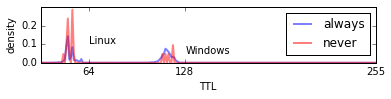

In [46]:
# Negotiation TTL spectrum
def ttl_spectrum(df, col):
    grp = df.groupby(np.digitize(df[col], np.linspace(0,255,256)))
    ser = grp[col].count() / len(df)
    ser.index = ser.index + (-1)
    ser = ser.reindex(np.linspace(0,255,256), fill_value=0)
    return ser

ttl_col = 'ttl-lon'

ettl = ttl_spectrum(df_works,ttl_col)
nttl = ttl_spectrum(df_totally_broken,ttl_col)

plt.figure(figsize=(6,1))
plt.plot(ettl.index, ettl, color="b", lw=2, alpha=0.50, label="always")
plt.plot(nttl.index, nttl, color="r", lw=2, alpha=0.50, label="never")
plt.annotate("Linux", xy=(65,0.1))
plt.annotate("Windows", xy=(129,0.05))
plt.legend()
plt.xlim(32,255)
plt.yticks([0,0.1,0.2])
plt.xticks([64,128,255])
plt.ylabel("density")
plt.xlabel("TTL")
plt.savefig("connttl.png", dpi=120, bbox_inches="tight")

In [47]:
HTML("<table><tr><th></th><th>Linux</th><th>Windows</th></tr>"
     "<tr><td style=\"color:blue;font-weight:bold;\">always</td><td>{}</td><td>{}</td></tr>"
     "<tr><td style=\"color:red;font-weight:bold;\">never</td><td>{}</td><td>{}</td></tr>"
     "<tr><td style=\"color:purple;font-weight:bold;\">other</td><td>{}</td><td>{}</td></tr></table>".format(
     (df_works[ttl_col] <= 64).sum(), (df_works[ttl_col] > 64).sum(),
     (df_totally_broken[ttl_col] <= 64).sum(), (df_totally_broken[ttl_col] > 64).sum(),
     (df_works_per_site_not[ttl_col] <= 64).sum(), (df_works_per_site_not[ttl_col] > 64).sum()))

,Linux,Windows
always,3159,3358
never,16,5
other,373,98


In [48]:
df_works['ecnNegotiated-lon'].sum()/len(df_works)

0.45787939235844716

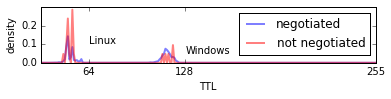

In [49]:
ttl_col = 'ttl-lon'
ecnNegotiated_col = 'ecnNegotiated-lon'

nego_ettl = ttl_spectrum(df_works[df_works[ecnNegotiated_col]],ttl_col)
nego_nttl = ttl_spectrum(df_works[-df_works[ecnNegotiated_col]],ttl_col)

plt.figure(figsize=(6,1))
plt.plot(ettl.index, ettl, color="b", lw=2, alpha=0.50, label="negotiated")
plt.plot(nttl.index, nttl, color="r", lw=2, alpha=0.50, label="not negotiated")
plt.annotate("Linux", xy=(65,0.1))
plt.annotate("Windows", xy=(129,0.05))
plt.legend()
plt.xlim(32,255)
plt.yticks([0,0.1,0.2])
plt.xticks([64,128,255])
plt.ylabel("density")
plt.xlabel("TTL")
plt.savefig("negottl.png", dpi=120, bbox_inches="tight")

In [50]:
df_works_ecn = df_works[df_works[ecnNegotiated_col]]
df_works_ecn_not = df_works[-df_works[ecnNegotiated_col]]

HTML("<table><tr><th style=\"color:blue;font-weight:bold;\">always</th><th>Linux</th><th>Windows</th></tr>"
     "<tr><td style=\"font-weight:bold;\">negotiated</td><td>{} ({:.0%})</td><td>{} ({:.0%})</td></tr>"
     "<tr><td style=\"font-weight:bold;\">not negotiated</td><td>{} ({:.0%})</td><td>{} ({:.0%})</td></tr></table>".format(
    (df_works_ecn[ttl_col] <= 64).sum(), (df_works_ecn[ttl_col] <= 64).sum()/len(df_works),
    (df_works_ecn[ttl_col] > 64).sum(), (df_works_ecn[ttl_col] > 64).sum()/len(df_works),
    (df_works_ecn_not[ttl_col] <= 64).sum(), (df_works_ecn_not[ttl_col] <= 64).sum()/len(df_works),
    (df_works_ecn_not[ttl_col] > 64).sum(), (df_works_ecn_not[ttl_col] > 64).sum()/len(df_works)))

always,Linux,Windows
negotiated,2827 (43%),157 (2%)
not negotiated,332 (5%),3201 (49%)


### ECN site & path analysis

In [51]:
#ecn_nego_on_attempt = ((df_online[mask_works])['prop-negotiated'] > 0).sum()
#print("{} ({:.2%}): Number of connections where ecn has actually been negotiated on successful connect.".format(ecn_nego_on_attempt, ecn_nego_on_attempt / ecn_understood_all_mask.sum()))

(34140, 34690)

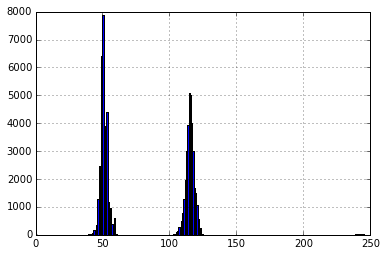

In [52]:
df[df['connstate']]['ttl'].hist(bins=255)
(df['connstate'] & (df['ttl'] < 80)).sum(), (df['connstate'] & (df['ttl'] > 80)).sum()
#df[df['connstate']].sort('ttl')